# CS 135 day05 : Regularization

# Ridge (L2) and LASSO (L1) Penalties for Linear Regression

# Objectives

* Learn how to avoid overfitting by including an L2-penalty on weight coefficients in training loss
* * Known as "Ridge" regression
* Learn how to avoid overfitting by including an L1-penalty on weight coefficients
* * Known as "Lasso" regression

# Outline
* [Part 1: Ridge Regression](#part1)
* [Part 2: MinMaxScalar](#part2)
* [Part 3: Lasso Regression](#part3)

# Prerequisites

Assumes you know a bit about sklearn Pipelines. For a quick intro, see day04 lab.

# Takeaways

* In practice, be sure to *rescale* all individual features to common range before using Ridge or Lasso
* Ridge is simple to use and simple to train
* Lasso can be better for *feature selection*, where we want to know which subset of provided features are useful for prediction (and which could be omitted because their weights are set to exactly zero)
* Lasso is more tricky to train (don't write yourself!) but good libraries like sklearn make it easy


In [104]:
import numpy as np

# Import the pandas (data management library)
import pandas as pd

In [105]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [106]:
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.metrics

# Step 1: Simple sine-wave dataset

Just like in the day04 lab, except we will add a large vertical offset ("bias")

This large offset of 42.0 ensures that we follow ProTip #1 from lecture: do not penalize bias term

In [107]:
SEED = 12345
prng = np.random.RandomState(SEED)

In [108]:
def true_prediction_function(x):
    return 42.0 + 2.0 * np.sin(2.1 * x)

In [109]:
L = 9        # num training examples

x_tr_L = np.linspace(-3, 3, L) + 0.09 * prng.randn(L)
y_tr_L = true_prediction_function(x_tr_L) + 0.06 * prng.randn(L)

In [110]:
M = 500      # num testing examples (to show "true" generalization)

x_te_M = np.linspace(-4, 4, M)
y_te_M = true_prediction_function(x_te_M) + 0.06 * prng.randn(M)

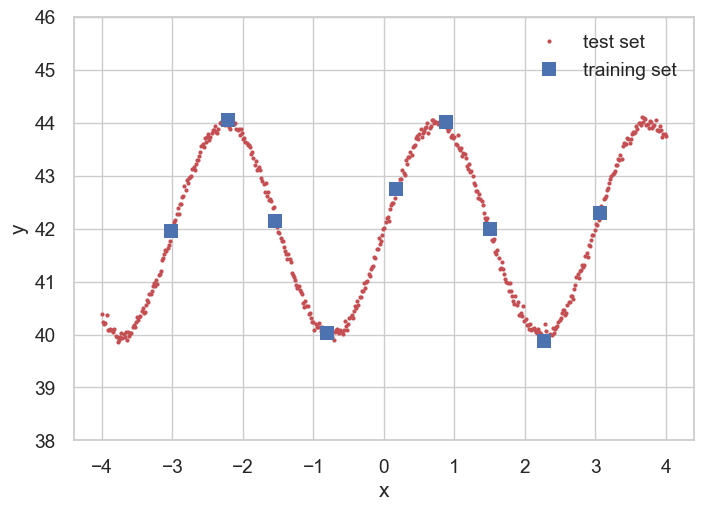

In [111]:
plt.plot(x_te_M, y_te_M, 'r.', label='test set')
plt.plot(x_tr_L, y_tr_L, 'bs', markersize=10, label='training set')

plt.legend(loc='upper right');
plt.xlabel('x');
plt.ylabel('y');
plt.ylim([42 - 4, 42 + 4]);

In [112]:
# Reshape all 'x' arrays so they are 2D with shape (n_examples, 1)

x_tr_L1 = x_tr_L.reshape((L,1))
x_te_M1 = x_te_M.reshape((M,1))

## Utility function for printing out learned weights + bias values

In [113]:
def pretty_print_weights(pipeline):
    preproc = pipeline.named_steps['preproc']
    feat_names = preproc.get_feature_names_out(['x'])
    for ff in range(len(feat_names)):
        coef_val_ff = pipeline.named_steps['regr'].coef_[ff]
        if np.allclose(coef_val_ff, 0):
            w_ff_str = "   0      exactly"
        else:
            w_ff_str = "% 8.3f" % coef_val_ff
        print("Feature %5s: weight coef %s" % (feat_names[ff], w_ff_str))
            
    print("Intercept    : weight coef % 8.3f" % (pipeline.named_steps['regr'].intercept_))

# Part 1: Comparing Ridge to unpenalized LinearRegression

In [114]:
lin_regr_pipeline = sklearn.pipeline.Pipeline([
        ("preproc", sklearn.preprocessing.PolynomialFeatures(10, include_bias=False)),
        ("regr", sklearn.linear_model.LinearRegression()),
        ])

In [115]:
lin_regr_pipeline.fit(x_tr_L1, y_tr_L);

In [116]:
yhat_N = lin_regr_pipeline.predict(x_tr_L1)
print("Training set error: % .3f" % (sklearn.metrics.mean_squared_error(yhat_N, y_tr_L)))

Training set error:  0.000


In [117]:
pretty_print_weights(lin_regr_pipeline)

Feature     x: weight coef    2.663
Feature   x^2: weight coef   -0.455
Feature   x^3: weight coef    0.385
Feature   x^4: weight coef   -0.057
Feature   x^5: weight coef   -1.267
Feature   x^6: weight coef    0.161
Feature   x^7: weight coef    0.304
Feature   x^8: weight coef   -0.040
Feature   x^9: weight coef   -0.019
Feature  x^10: weight coef    0.003
Intercept    : weight coef   42.281


#### Try Ridge with SMALL alpha = 0.01

In [118]:
ridge_small_alpha_pipeline = sklearn.pipeline.Pipeline([
        ("preproc", sklearn.preprocessing.PolynomialFeatures(10, include_bias=False)),
        ("regr", sklearn.linear_model.Ridge(alpha=0.01)),   # <<< LOOK, Ridge regression with alpha = 0.01
        ])

In [119]:
ridge_small_alpha_pipeline.fit(x_tr_L1, y_tr_L);

In [120]:
yhat_N = ridge_small_alpha_pipeline.predict(x_tr_L1)
print("Training set error: % .3f" % (sklearn.metrics.mean_squared_error(yhat_N, y_tr_L)))

Training set error:  0.000


In [121]:
pretty_print_weights(ridge_small_alpha_pipeline)

Feature     x: weight coef    2.632
Feature   x^2: weight coef   -0.436
Feature   x^3: weight coef    0.383
Feature   x^4: weight coef   -0.054
Feature   x^5: weight coef   -1.253
Feature   x^6: weight coef    0.152
Feature   x^7: weight coef    0.301
Feature   x^8: weight coef   -0.038
Feature   x^9: weight coef   -0.019
Feature  x^10: weight coef    0.003
Intercept    : weight coef   42.275


### Discussion 1a: How do these new weight values compare to the previous unpenalized model?

Are they similar? Smaller magnitude? Bigger magnitude?

Slightly large in magnitude, but not noticeably so.

TODO write code here to count how many of the weights have a larger absolute value with alpha = 0.0 

In [122]:
num_larger = 0
ridge_small_alpha_pipeline

Pipeline(steps=[('preproc', PolynomialFeatures(degree=10, include_bias=False)),
                ('regr', Ridge(alpha=0.01))])

### Try Ridge with BIG alpha = 1000.0

In [123]:
ridge_big_alpha_pipeline = sklearn.pipeline.Pipeline([
        ("preproc", sklearn.preprocessing.PolynomialFeatures(9, include_bias=False)),
        ("regr", sklearn.linear_model.Ridge(alpha=1000.0)),  # <<< LOOK, Ridge regression with alpha = 1000
        ])

In [124]:
ridge_big_alpha_pipeline.fit(x_tr_L1, y_tr_L);

In [125]:
yhat_N = ridge_big_alpha_pipeline.predict(x_tr_L1)
print("Training set error: % .3f" % (sklearn.metrics.mean_squared_error(yhat_N, y_tr_L)))

Training set error:  0.932


In [126]:
pretty_print_weights(ridge_big_alpha_pipeline)

Feature     x: weight coef    0.004
Feature   x^2: weight coef   -0.000
Feature   x^3: weight coef    0.002
Feature   x^4: weight coef   -0.001
Feature   x^5: weight coef   -0.002
Feature   x^6: weight coef   -0.001
Feature   x^7: weight coef   -0.015
Feature   x^8: weight coef   -0.000
Feature   x^9: weight coef    0.002
Intercept    : weight coef   42.189


### Exercise 1b: Try Ridge with HUGE alpha = 100000.0

Can you predict what will happen to the learned weights? What about the learned intercept?

In [127]:
# TODO write code here
ridge_HUGE_alpha_pipeline = sklearn.pipeline.Pipeline([
        ("preproc", sklearn.preprocessing.PolynomialFeatures(9, include_bias=False)),
        ("regr", sklearn.linear_model.Ridge(alpha=100000.0)),  # <<< LOOK, Ridge regression with alpha = 1000
        ])

ridge_HUGE_alpha_pipeline.fit(x_tr_L1, y_tr_L)
yhat_N = ridge_big_alpha_pipeline.predict(x_tr_L1)
print("Training set error: % .3f" % (sklearn.metrics.mean_squared_error(yhat_N, y_tr_L)))
pretty_print_weights(ridge_HUGE_alpha_pipeline)



Training set error:  0.932
Feature     x: weight coef   -0.000
Feature   x^2: weight coef   -0.000
Feature   x^3: weight coef   -0.000
Feature   x^4: weight coef   -0.000
Feature   x^5: weight coef   -0.001
Feature   x^6: weight coef   -0.000
Feature   x^7: weight coef   -0.004
Feature   x^8: weight coef    0.000
Feature   x^9: weight coef    0.000
Intercept    : weight coef   42.148


### Discussion 1c: Why does the intercept behave the way it does here?

In [128]:
# TODO write explanation here
# We didn't apply the bias to the intercept

### Exercise 1d: Why do we set `include_bias=False` in these pipelines? What happens otherwise?

In [129]:
# TODO write here
# Bias gets scaled

### Exercise 1d: Can you plot the predictions on the test set for the pipelines above?

Does the small alpha result still essentially perfectly reconstruct the training data?

What about the big alpha value? The HUGE alpha value?

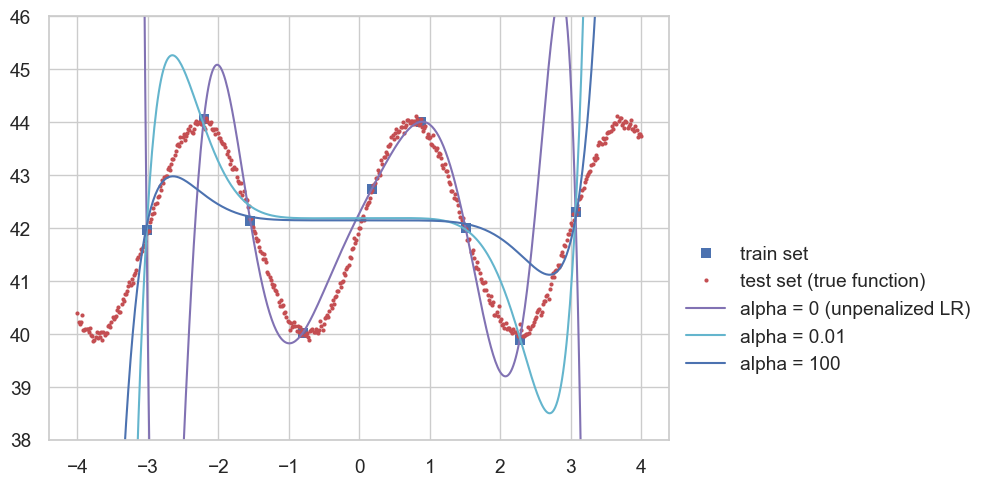

In [130]:
plt.plot(x_tr_L, y_tr_L, 'bs', markersize=7, label='train set')
plt.plot(x_te_M, y_te_M, 'r.', label='test set (true function)')


plt.plot(x_te_M, lin_regr_pipeline.predict(x_te_M1), 'm-', label='alpha = 0 (unpenalized LR)')
plt.plot(x_te_M, ridge_big_alpha_pipeline.predict(x_te_M1), 'c-', label='alpha = 0.01')   # TODO fix this line
plt.plot(x_te_M, ridge_HUGE_alpha_pipeline.predict(x_te_M1), 'b-', label='alpha = 100')  # TODO fix this line

plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.ylim([42 - 4, 42 + 4]);

# Part 2: Rescaling  

What is happening inside our regression pipeline?

Let's look at the feature transformation to find out.

Remember, we are putting in a scalar $x$

Our high-degree polynomial features are producing 9-th deg poly features

$\phi(x) = [x ~~ x^2 ~~ x^3 ~~ \ldots x^9 ]$

Can we visualize these?

In [131]:
np.set_printoptions(precision=2, suppress=True, linewidth=100)

print("============= Displaying transformed features of Polynomial Features + Ridge pipeline")
print("Raw features:")
print(x_tr_L1)

step1_NF = ridge_big_alpha_pipeline.steps[0][1].transform(x_tr_L1)
print("After step 1: new shape is " + str(step1_NF.shape))
print(step1_NF)


============= Displaying transformed features of Polynomial Features + Ridge pipeline
Raw features:
[[-3.02]
 [-2.21]
 [-1.55]
 [-0.8 ]
 [ 0.18]
 [ 0.88]
 [ 1.51]
 [ 2.28]
 [ 3.07]]
After step 1: new shape is (9, 9)
[[    -3.02      9.11    -27.5      83.01   -250.55    756.28  -2282.77   6890.36 -20798.01]
 [    -2.21      4.87    -10.75     23.72    -52.35    115.53   -254.96    562.67  -1241.75]
 [    -1.55      2.39     -3.7       5.72     -8.85     13.69    -21.18     32.76    -50.67]
 [    -0.8       0.64     -0.51      0.41     -0.33      0.26     -0.21      0.17     -0.13]
 [     0.18      0.03      0.01      0.        0.        0.        0.        0.        0.  ]
 [     0.88      0.77      0.67      0.59      0.51      0.45      0.39      0.34      0.3 ]
 [     1.51      2.28      3.43      5.18      7.81     11.78     17.76     26.79     40.42]
 [     2.28      5.18     11.78     26.8      60.99    138.77    315.75    718.45   1634.73]
 [     3.07      9.42     28.91     88.7

Read about MinMaxScaler here:

<https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html>

Let's add a min-max scalar to our pipeline

In [132]:
rescaled_ridge_big_alpha_pipeline = sklearn.pipeline.Pipeline([
        ('rescale', sklearn.preprocessing.MinMaxScaler()),
        ("preproc", sklearn.preprocessing.PolynomialFeatures(10, include_bias=False)),
        ("regr", sklearn.linear_model.Ridge(alpha=100.0)),   # <<< LOOK, Ridge regression with alpha = 0.0001
        ])

Let's fit that pipeline to our dataset

In [133]:
rescaled_ridge_big_alpha_pipeline.fit(x_tr_L1, y_tr_L);

OK, now, we inspect the features produced after each step

In [134]:
np.set_printoptions(precision=2, suppress=True, linewidth=100)

print("============= Displaying transformed features of MinMaxScalar + Polynomial Features + Ridge pipeline")

print("Raw features:")
print(x_tr_L1)

step1_NF = rescaled_ridge_big_alpha_pipeline.steps[0][1].transform(x_tr_L1)
print("After step 1: new shape is " + str(step1_NF.shape))
print(step1_NF)

step2_NG = rescaled_ridge_big_alpha_pipeline.steps[1][1].transform(step1_NF)
print("After step 2: new shape is " + str(step2_NG.shape))
print(step2_NG)

============= Displaying transformed features of MinMaxScalar + Polynomial Features + Ridge pipeline
Raw features:
[[-3.02]
 [-2.21]
 [-1.55]
 [-0.8 ]
 [ 0.18]
 [ 0.88]
 [ 1.51]
 [ 2.28]
 [ 3.07]]
After step 1: new shape is (9, 1)
[[0.  ]
 [0.13]
 [0.24]
 [0.36]
 [0.52]
 [0.64]
 [0.74]
 [0.87]
 [1.  ]]
After step 2: new shape is (9, 10)
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.13 0.02 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.24 0.06 0.01 0.   0.   0.   0.   0.   0.   0.  ]
 [0.36 0.13 0.05 0.02 0.01 0.   0.   0.   0.   0.  ]
 [0.52 0.28 0.14 0.08 0.04 0.02 0.01 0.01 0.   0.  ]
 [0.64 0.41 0.26 0.17 0.11 0.07 0.04 0.03 0.02 0.01]
 [0.74 0.55 0.41 0.31 0.23 0.17 0.13 0.09 0.07 0.05]
 [0.87 0.76 0.66 0.57 0.5  0.43 0.38 0.33 0.28 0.25]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]]


### Discussion 2b: What do you think is the benefit of using MinMaxScalar before PolynomialFeatures?

Weights end up as lesser magnitude, less overfitting.

TODO Write your explanation here

### BONUS Exercise 2c: What math operation is performed by MinMaxScalar?

**If you are pressed for time, skip this and look at Part 3 below **

See if you can use the code below to get an idea

Hint, look at the min and max values of the training set

In [135]:
print("Smallest training set x = % 9.3f" % (x_tr_L.min()))
print("Smallest training set x = % 9.3f" % (x_tr_L.max()))

Smallest training set x =    -3.018
Smallest training set x =     3.069


In [136]:
pretrained_mm_scaler = rescaled_ridge_big_alpha_pipeline.steps[0][1] # Unpack from the pipeline

In [137]:
for x in np.linspace(-5, 5, 11):
    phi_11 = pretrained_mm_scaler.transform(np.asarray([[x]]))
    phi = float(phi_11[0][0]) # convert to float from a 2D array of size (1,1)
    print("x = % 9.3f | \phi(x) = % 9.3f" % (x, phi))

x =    -5.000 | \phi(x) =    -0.326
x =    -4.000 | \phi(x) =    -0.161
x =    -3.000 | \phi(x) =     0.003
x =    -2.000 | \phi(x) =     0.167
x =    -1.000 | \phi(x) =     0.332
x =     0.000 | \phi(x) =     0.496
x =     1.000 | \phi(x) =     0.660
x =     2.000 | \phi(x) =     0.824
x =     3.000 | \phi(x) =     0.989
x =     4.000 | \phi(x) =     1.153
x =     5.000 | \phi(x) =     1.317


<a id="part3"></a>

# Part 3: Lasso Regression

### LASSO with small alpha value (0.001)

In [138]:
lasso_small_alpha_pipeline = sklearn.pipeline.Pipeline([
        ('rescale', sklearn.preprocessing.MinMaxScaler()),
        ("preproc", sklearn.preprocessing.PolynomialFeatures(10, include_bias=False)),
        ("regr", sklearn.linear_model.Lasso(alpha=0.001, max_iter=1000000)), # LASSO with alpha = 0.1
        ])

In [139]:
lasso_small_alpha_pipeline.fit(x_tr_L1, y_tr_L);

In [140]:
yhat_N = lasso_small_alpha_pipeline.predict(x_tr_L1)
print("Training set error: % .3f" % (sklearn.metrics.mean_squared_error(yhat_N, y_tr_L)))

Training set error:  1.057


In [141]:
pretty_print_weights(lasso_small_alpha_pipeline)

Feature     x: weight coef   -5.623
Feature   x^2: weight coef    0      exactly
Feature   x^3: weight coef   26.805
Feature   x^4: weight coef    0      exactly
Feature   x^5: weight coef    0      exactly
Feature   x^6: weight coef  -54.234
Feature   x^7: weight coef    0      exactly
Feature   x^8: weight coef    0      exactly
Feature   x^9: weight coef    0      exactly
Feature  x^10: weight coef   32.415
Intercept    : weight coef   42.860


### LASSO with moderate alpha value (0.03)

In [142]:
lasso_moderate_alpha_pipeline = sklearn.pipeline.Pipeline([
        ('rescale', sklearn.preprocessing.MinMaxScaler()),
        ("preproc", sklearn.preprocessing.PolynomialFeatures(10, include_bias=False)),
        ("regr", sklearn.linear_model.Lasso(alpha=0.03, max_iter=100000)), # LASSO with alpha = 0.1
        ])

In [143]:
lasso_moderate_alpha_pipeline.fit(x_tr_L1, y_tr_L);

In [144]:
yhat_N = lasso_moderate_alpha_pipeline.predict(x_tr_L1)
print("Training set error: % .3f" % (sklearn.metrics.mean_squared_error(yhat_N, y_tr_L)))

Training set error:  1.825


In [145]:
pretty_print_weights(lasso_moderate_alpha_pipeline)

Feature     x: weight coef    0      exactly
Feature   x^2: weight coef   -0.616
Feature   x^3: weight coef    0      exactly
Feature   x^4: weight coef    0      exactly
Feature   x^5: weight coef    0      exactly
Feature   x^6: weight coef    0      exactly
Feature   x^7: weight coef    0      exactly
Feature   x^8: weight coef    0      exactly
Feature   x^9: weight coef    0      exactly
Feature  x^10: weight coef    0      exactly
Intercept    : weight coef   42.343


### Discussion 3a: What is the advantage of learning that some weights are indistiguishable from zero? 

Hints: How can this help with runtime or storage costs? Interpretability?

### LASSO with an even LARGER alpha value (0.1)

In [ ]:
lasso_big_alpha_pipeline = sklearn.pipeline.Pipeline([
        ('rescale', sklearn.preprocessing.MinMaxScaler()),
        ("preproc", sklearn.preprocessing.PolynomialFeatures(10, include_bias=False)),
        ("regr", sklearn.linear_model.Lasso(alpha=0.1, max_iter=100000)), # LASSO with alpha = 0.1
        ])

In [ ]:
lasso_big_alpha_pipeline.fit(x_tr_L1, y_tr_L);

In [ ]:
yhat_N = lasso_big_alpha_pipeline.predict(x_tr_L1)
print("Training set error: % .3f" % (sklearn.metrics.mean_squared_error(yhat_N, y_tr_L)))

Training set error:  1.905


In [ ]:
pretty_print_weights(lasso_big_alpha_pipeline)

Feature     x: weight coef    0      exactly
Feature   x^2: weight coef    0      exactly
Feature   x^3: weight coef    0      exactly
Feature   x^4: weight coef    0      exactly
Feature   x^5: weight coef    0      exactly
Feature   x^6: weight coef    0      exactly
Feature   x^7: weight coef    0      exactly
Feature   x^8: weight coef    0      exactly
Feature   x^9: weight coef    0      exactly
Feature  x^10: weight coef    0      exactly
Intercept    : weight coef   42.124


### Discussion 3b: Why do you think the intercept is regularized differently than other weights?

Hint: Recall ProTip #1 from lecture

TODO write your answer here

### Tiny alpha value 

In [ ]:
lasso_tiny_alpha_pipeline = sklearn.pipeline.Pipeline([
        ('rescale', sklearn.preprocessing.MinMaxScaler()),
        ("preproc", sklearn.preprocessing.PolynomialFeatures(10, include_bias=False)),
        ("regr", sklearn.linear_model.Lasso(alpha=0.00001, max_iter=1000000)),         # LASSO!
        ])

In [ ]:
lasso_tiny_alpha_pipeline.fit(x_tr_L1, y_tr_L);

/Users/mhughes/micromamba/envs/cs135_25s_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e-01, tolerance: 1.714e-03
  model = cd_fast.enet_coordinate_descent(


In [ ]:
yhat_N = lasso_tiny_alpha_pipeline.predict(x_tr_L1)
print("Training set error: % .3f" % (sklearn.metrics.mean_squared_error(yhat_N, y_tr_L)))

Training set error:  0.060


In [ ]:
pretty_print_weights(lasso_tiny_alpha_pipeline)

Feature     x: weight coef   68.733
Feature   x^2: weight coef -537.607
Feature   x^3: weight coef  1193.768
Feature   x^4: weight coef -530.871
Feature   x^5: weight coef -610.172
Feature   x^6: weight coef    0      exactly
Feature   x^7: weight coef  282.169
Feature   x^8: weight coef  335.437
Feature   x^9: weight coef   13.959
Feature  x^10: weight coef -215.063
Intercept    : weight coef   41.958


### Discussion 3c: What do you think that convergence warning means? What might you do to address it?

TODO